In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report


In [49]:
goalies_df = pd.read_csv("data/goalies_2023.csv")
goalies_df = goalies_df[goalies_df["situation"] == "all"]

goalies_df["save_percentage"] = (goalies_df["ongoal"] - goalies_df["goals"]) / goalies_df["ongoal"]

shots_df = pd.read_csv("data/shots_2023.csv")
shots_df = shots_df[shots_df["shotOnEmptyNet"] == 0]
position_mapping = {'C': 0, 'L': 1, 'R': 2, 'D': 3}
shots_df['playerPositionThatDidEvent'] = shots_df['playerPositionThatDidEvent'].map(position_mapping)

merged_df = pd.merge(
    shots_df,
    goalies_df,
    left_on='goalieIdForShot',
    right_on='playerId',
    how='left'
)

merged_df.head()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,save_percentage
0,1,11.313708,81.0,81.0,8.0,8.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
1,2,45.343136,55.0,55.0,30.0,30.0,-3.8,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
2,3,43.139309,58.0,58.0,-30.0,30.0,-3.4,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233
3,4,42.201896,-64.0,64.0,34.0,34.0,-15.0,0,0,0,...,20.89,26.31,26.95,32.0,34.0,17.0,363.0,0.0,0.0,0.889628
4,5,19.924859,83.0,83.0,19.0,19.0,-5.6,0,0,0,...,52.13,56.40,61.50,66.0,60.0,47.0,994.0,2.0,1.0,0.906233


## Visualization of the shots against a particular goalie

This is used to verify if the data has the features we want

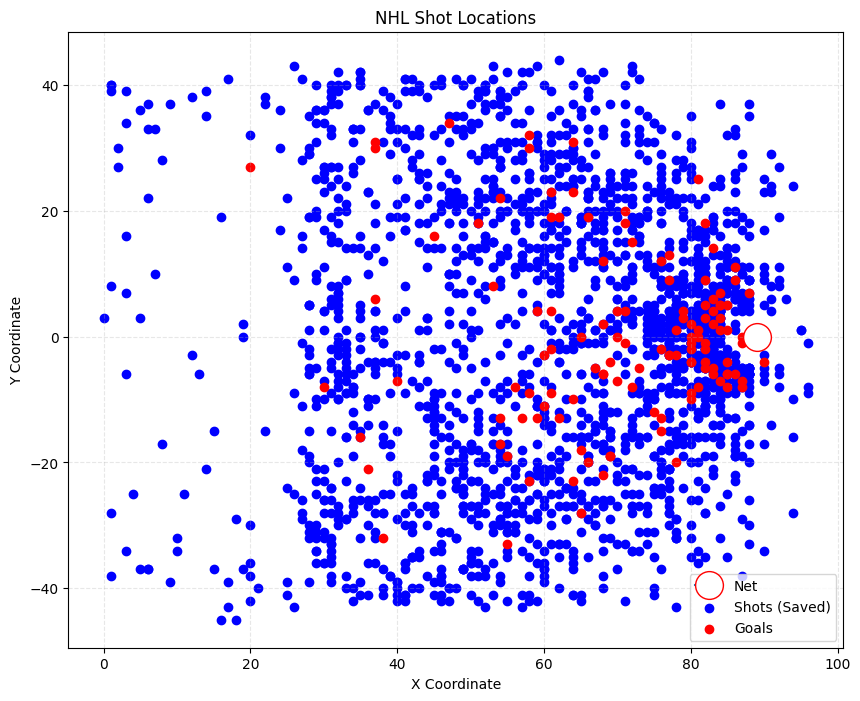

In [75]:
goalie_name = "Thatcher Demko"
goalie_id = goalies_df[goalies_df["name"] == goalie_name]["playerId"].values[0]

example_df = merged_df[merged_df["goalieIdForShot"] == goalie_id]

plt.figure(figsize=(10, 8))

plt.plot(89, 0, marker="o", markersize=20, markeredgecolor="red", markerfacecolor="white", label="Net")

goals = example_df[example_df['goal'] == 1]
non_goals = example_df[example_df['goal'] == 0]

plt.scatter(abs(non_goals['arenaAdjustedXCord']), non_goals['arenaAdjustedYCord'], 
            color='blue', label='Shots (Saved)')

plt.scatter(abs(goals['arenaAdjustedXCord']), goals['arenaAdjustedYCord'], 
            color='red', label='Goals')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('NHL Shot Locations')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


In [ ]:
features = ["arenaAdjustedXCord", "arenaAdjustedYCord", "speedFromLastEvent", "shotAngle", "shotDistance", "shotRebound", "shotWasOnGoal", "shotRush", "homeSkatersOnIce", "awaySkatersOnIce", "playerPositionThatDidEvent"]

X = merged_df[features]
y = merged_df["goal"]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, train_size=0.8)

oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(train_X, train_y)

In [82]:
model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 15})
model.fit(train_X, train_y)

RandomForestClassifier(class_weight={0: 1, 1: 15}, random_state=42)

In [83]:
predictions = model.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
mae = mean_absolute_error(test_y.values, predictions)
print(f"Accuracy: {accuracy}, Mean Absolute Error: {mae}")

print(classification_report(test_y, predictions))


Accuracy: 0.9308969826523061, Mean Absolute Error: 0.06910301734769382
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22755
           1       0.25      0.04      0.06      1571

    accuracy                           0.93     24326
   macro avg       0.60      0.51      0.51     24326
weighted avg       0.89      0.93      0.91     24326

